**Примечание**

Я направляю не финализированную работу, так как на текущий момент столкнулась с проблемами по ходу выполнения проекта и не могу их разрешить самостоятельно, оосбенно в условиях ограниченности по времени, которое (из-за работы) могу проекту уделить.

По итогу векторизации изображений и текстов я получаю списки, координаты векторов. Однако далее запустить по ним обучение не представляется возможным.

Информация, которую нашла в интернете, не смогла помочь решить мне эту проблему за прошедшие 3 потраченных на проект дня. Подскажи, пожалуйста, что я делаю в данном случае не так. Возможно где-то по тексту также будут моменты, которые я сделала некорректно. Заранее благодарю за помощь и обратную связь.

# Поиск по изображениям (сборный проект-5)

**Общая вводная информация**

Проект выполнен для фотохостинга для профессиональных фотографов "Со Смыслом" (“With Sense”). 

Пользователи размещают свои фотографии на хостинге и сопровождают их полным описанием: указывают место съёмок, модель камеры и т. д. Отличительная особенность сервиса — описание: его может предоставить не только тот, кто размещает фотографию, но и другие пользователи портала.

Разрабатывается проект по поиску референсных фотографий по текстовому запросу. 

Целью данного проекта является создание демонстрационной версии для проверки данной концепции на возможность реализации. 

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.


В рамках исследования будут использоваться модели:
- Линейная регрессия.
- Полносвязная нейронная сеть.
- Случайный лес.

Для выбора лучшей модели будет использоваться метрика качества RMSE. Среднеквадратичная ошибка хорошо показывает себя в задачах регрессии, где необходимо оценить отклонение предсказанных значений от истинных значений в тех же единицах измерения. Кроме того, метрика более чувствительна к выбросам чем MAE.

**Описание данных**

В файле *train_dataset.csv* находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.

В папке *train_images* содержатся изображения для тренировки модели.

В файле *CrowdAnnotations.tsv* — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

- Имя файла изображения.
- Идентификатор описания.
- Доля людей, подтвердивших, что описание соответствует изображению.
- Количество человек, подтвердивших, что описание соответствует изображению.
- Количество человек, подтвердивших, что описание не соответствует изображению.

В файле *ExpertAnnotations.tsv* содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

- Имя файла изображения.
- Идентификатор описания.
- 3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле *test_queries.csv* находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.

В папке *test_images* содержатся изображения для тестирования модели.

**Юридические ограничения**

В некоторых странах, где работает компания With Sense, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно, текстов, изображений, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16-ти лет.

Ввиду этого в данном проекте проблемный контент будет удален из тренировочных данных. Во время тестирования модели при появлении в запросе “вредного” контента должен отображаться дисклеймер. 

## Импорты и константы

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import mode

import re
from tqdm import tqdm
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer

from IPython.display import display, Image
import os

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Dense, GlobalAveragePooling2D, Dropout, Flatten, BatchNormalization

from sklearn.model_selection import GridSearchCV, GroupShuffleSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [48]:
path = 'ds_project_5/to_upload/'

random_state = 7
seed = 7
np.random.seed(random_state)  

## Загрузка и предварительная оценка данных

Сначала загружаем и оцениваем табличные данные.

In [49]:
train_data = pd.read_csv(path + 'train_dataset.csv')
test_data = pd.read_csv(path + 'test_queries.csv', sep='|')

crowd = pd.read_table(path + 'CrowdAnnotations.tsv', header=None, names=['image', 'query_id', 'positive_share', 'positive_count', 'negative_count'])
expert = pd.read_table(path + 'ExpertAnnotations.tsv', header=None, names=['image', 'query_id', 'expert_1', 'expert_2', 'expert_3'])

In [50]:
expert.head(5)

,image,query_id,expert_1,expert_2,expert_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


In [51]:
#Зададим функцию, которая выведет обзор данных из датасета
def parse(ds):
    print('\033[1mПервые 5 строк датасета\033[0m')
    display(ds.head(5))
    
    print('\n\033[1mИнформация о структуре датасета:\033[0m')
    ds.info()
    
    #Проверка на пропуски
    #Абсолютные
    total_missing = ds.isnull().sum()
    print(f'\n\033[1mВсего пропущенных значений:\n\033[0m{total_missing}')
    #Относительные
    rows = len(ds)
    columns = len(ds.columns)
    total_cells = rows * columns
    missing = round(total_missing / total_cells * 100, 2)
    print(f'\n\033[1mПропусков относительно всех ячеек:\n\033[0m{missing}%')

    #Проверка на наличие явных дубликатов
    duplicates = ds.duplicated().sum()
    print(f'\n\033[1mЯвных дубликатов, в строках:\n\033[0m{duplicates}')
    part_dup = round(duplicates / rows * 100, 2)
    print(f'\033[1mДоля явных дубликатов от общего количества строк:\n\033[0m{part_dup}%\n')

    #Уникальные значения категориальных столбцов
    cat_cols = ds.select_dtypes(exclude=['int', 'float']).columns
    print('\033[1mУникальные значения категориальных столбцов:\033[0m')
    for col in cat_cols:
        unique = ds[col].unique()
        print(f'{col}: {len(unique)} уникальных значений')

In [52]:
parse(train_data)

Первые 5 строк датасета


,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...



Информация о структуре датасета:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB

Всего пропущенных значений:
image         0
query_id      0
query_text    0
dtype: int64

Пропусков относительно всех ячеек:
image         0.0
query_id      0.0
query_text    0.0
dtype: float64%

Явных дубликатов, в строках:
0
Доля явных дубликатов от общего количества строк:
0.0%

Уникальные значения категориальных столбцов:
image: 1000 уникальных значений
query_id: 977 уникальных значений
query_text: 977 уникальных значений


In [53]:
parse(expert)

Первые 5 строк датасета


,image,query_id,expert_1,expert_2,expert_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2



Информация о структуре датасета:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   expert_1  5822 non-null   int64 
 3   expert_2  5822 non-null   int64 
 4   expert_3  5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB

Всего пропущенных значений:
image       0
query_id    0
expert_1    0
expert_2    0
expert_3    0
dtype: int64

Пропусков относительно всех ячеек:
image       0.0
query_id    0.0
expert_1    0.0
expert_2    0.0
expert_3    0.0
dtype: float64%

Явных дубликатов, в строках:
0
Доля явных дубликатов от общего количества строк:
0.0%

Уникальные значения категориальных столбцов:
image: 1000 уникальных значений
query_id: 977 уникальных значений


In [54]:
parse(crowd)

Первые 5 строк датасета


,image,query_id,positive_share,positive_count,negative_count
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3



Информация о структуре датасета:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image           47830 non-null  object 
 1   query_id        47830 non-null  object 
 2   positive_share  47830 non-null  float64
 3   positive_count  47830 non-null  int64  
 4   negative_count  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB

Всего пропущенных значений:
image             0
query_id          0
positive_share    0
positive_count    0
negative_count    0
dtype: int64

Пропусков относительно всех ячеек:
image             0.0
query_id          0.0
positive_share    0.0
positive_count    0.0
negative_count    0.0
dtype: float64%

Явных дубликатов, в строках:
0
Доля явных дубликатов от общего количества строк:
0.0%

Уникальные значения категориальных столбцов:
image: 1000 уникальных значений
query_id: 10

In [55]:
parse(test_data)

Первые 5 строк датасета


,Unnamed: 0,query_id,query_text,image
0,0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg



Информация о структуре датасета:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  500 non-null    int64 
 1   query_id    500 non-null    object
 2   query_text  500 non-null    object
 3   image       500 non-null    object
dtypes: int64(1), object(3)
memory usage: 15.8+ KB

Всего пропущенных значений:
Unnamed: 0    0
query_id      0
query_text    0
image         0
dtype: int64

Пропусков относительно всех ячеек:
Unnamed: 0    0.0
query_id      0.0
query_text    0.0
image         0.0
dtype: float64%

Явных дубликатов, в строках:
0
Доля явных дубликатов от общего количества строк:
0.0%

Уникальные значения категориальных столбцов:
query_id: 500 уникальных значений
query_text: 500 уникальных значений
image: 100 уникальных значений


Отметим следующее:
- Тренировочные данные (train_data):
    - Содержат 5 822 строки для 1 000 уникальных изображений.
    - Нет явных дубликатов или пропусков значений.
    - Одно и тоже описание повторяется для нескольких изображений.
- Данные оценок экспертов (expert):
    - Содержат 5 822 строки для 1 000 уникальных изображений.
    - Нет явных дубликатов или пропусков значений.
    - Одно и тоже описание повторяется (оценивается) для нескольких изображений. 
- Данные оценок краудсорсинга (crowd):
    - Содержат 47 830 строк для 1 000 уникальных изображений.
    - В отличие от тренировочных данных и данных об оценках экспертов, количество уникальных значений идентификатора описания 1 000, а не 977.
    - Нет явных дубликатов или пропусков значений.
    - Для одного и того же изображения оценивают несколько разных описаний.
- Тестовые данные (test_data):
    - Содержат 500 строк для 100 уникальных изображений.
    - Нет явных дубликатов или пропусков значений.
    - Каждое изображение имеет по 5 текстовых описаний для оценки.

## Исследовательский анализ и подготовка данных

### Оценки соответствия текста и изображения

Из имеющихся данных имеются экспертные и краудсорсинговые оценки соответствия текста и изображения.

Краудсорсинговые оценки уже нормализованы (оценка лежит в диапазоне от 0 до 1).

Имеются отдельно данные от 3 экспертов с их оценкой в диапазоне от 1 до 4, соответственно их необходимо предварительно нормализовать. Кроме того, все 3 оценки необходимо привести к одной итоговой. Так как диапазон вариантов значений больше количества экспертов, есть вероятность, что для некоторых изображений невозможно будет выделить моду (наиболее часто встречаемое значение ряда, т.е. в данном случае та оценка, которую поставило большинство экспертов). Для таких случаев моду заменим на среднее арифметическое оценок экспертов (для сохранения максимального количества данных ввиду их ограниченности).

In [56]:
def res(rows):
    modes = rows.mode()
    if len(modes)>1:
        return rows.mean()
    else:
        return modes[0]

In [57]:
expert['result'] = expert[['expert_1', 'expert_2', 'expert_3']].apply(res, axis=1)

expert.head(5)

,image,query_id,expert_1,expert_2,expert_3,result
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,1.0
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,1.0
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,1.0
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,2.0
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,1.0


In [58]:
#Нормализуем полученные значения, чтобы они находились в диапазоне от 0 до 1
expert['result'] = expert['result'].apply(lambda x: (x-1)/3)

expert['result'].describe()

count    5822.000000
mean        0.208157
std         0.285431
min         0.000000
25%         0.000000
50%         0.000000
75%         0.333333
max         1.000000
Name: result, dtype: float64

Теперь оценим распределение оценок экспертов и краудсорсинга.

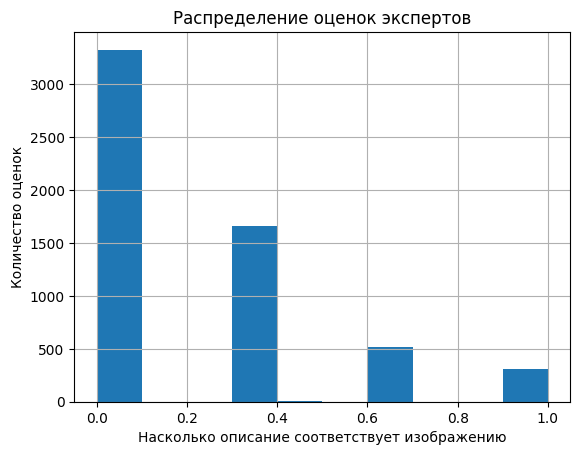

In [59]:
expert['result'].hist()
plt.title('Распределение оценок экспертов')
plt.xlabel('Насколько описание соответствует изображению')
plt.ylabel('Количество оценок')
plt.show()

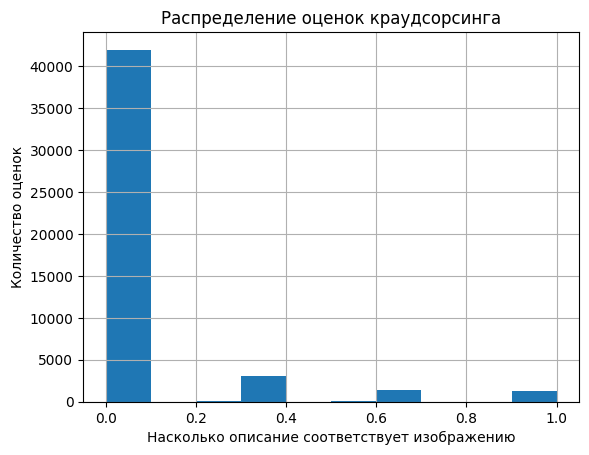

In [60]:
crowd['positive_share'].hist()
plt.title('Распределение оценок краудсорсинга')
plt.xlabel('Насколько описание соответствует изображению')
plt.ylabel('Количество оценок')
plt.show()

Обратим внимание, что оценки экспертов более сбалансированны, в то время как в краудсорсинговых очевиден перекос в данных в сторону 0% совпадения. Вероятно, это может быть связано со спецификой выставления оценок: исходя из описания данных, люди в краудсорсинговой компании оценивали описание по бинарной системе (соответствует или нет), в то время как эксперты могли использовать более широкий диапазон оценок.

Важно отметить, что в таком случае, использование краудсорсинговых оценок может сделать модель менее гибкой (например, если описание говорит об одном ребенке на фотографии, а на фотографии их 2 или больше, то модель проигнорирует такие фотографии и, вероятно, хуже научится определять ребенка в целом).

И хотя ввиду ограниченности в объеме имеющихся данных можно было бы рассмотреть возможность увеличения выборки таким образом, выберем только экспертные оценки для большей точность работы модели.

### Анализ изображений

Визуально оценим изображения в формате "как есть".

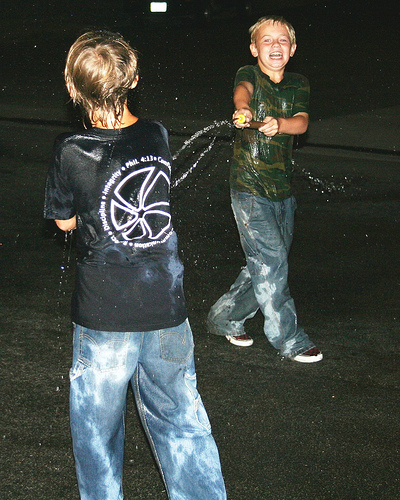

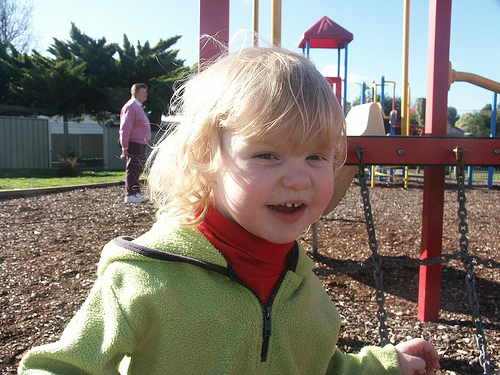

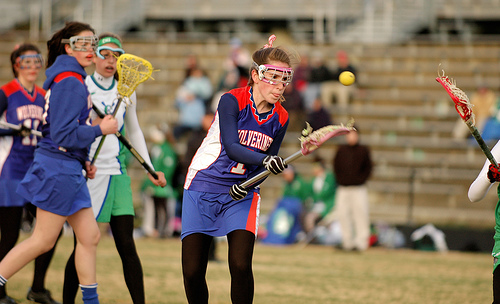

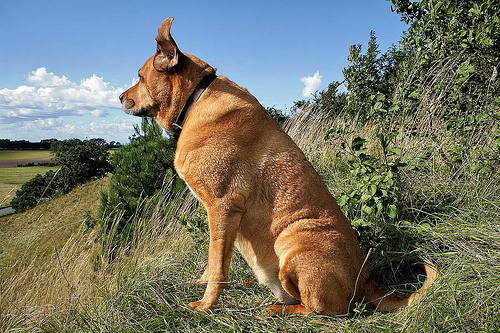

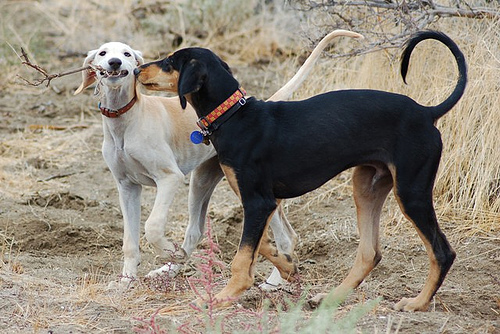

In [61]:
image_dir_tt = path + 'test_images/'

for img_name in os.listdir(image_dir_tt)[:5]:
    display(Image(filename=os.path.join(image_dir_tt, img_name)))

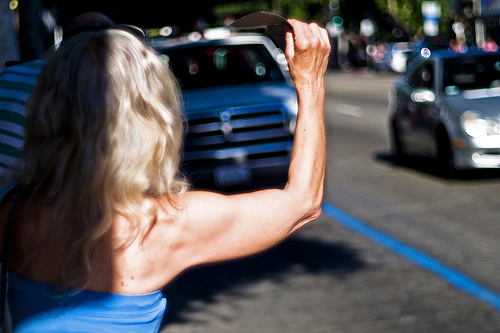

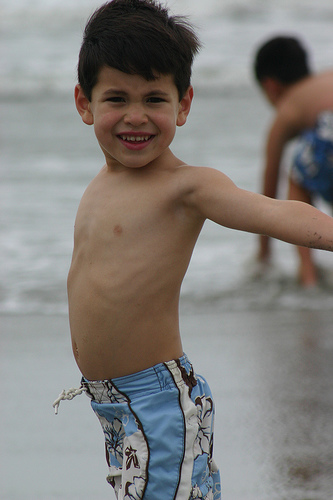

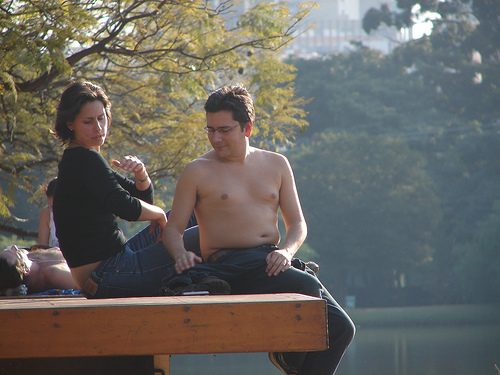

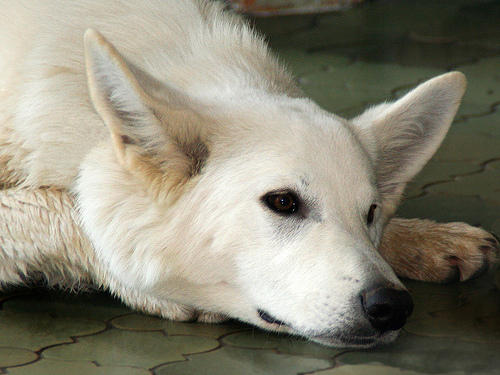

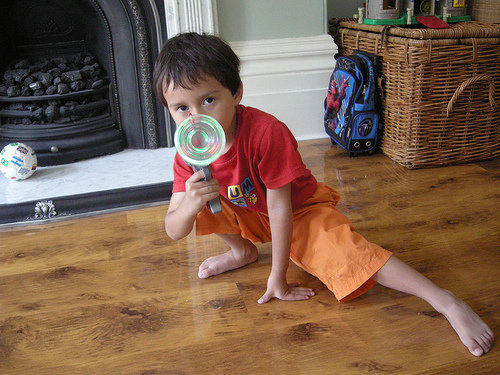

In [62]:
image_dir_tn = path + 'train_images/'

for img_name in os.listdir(image_dir_tn)[:5]:
    display(Image(filename=os.path.join(image_dir_tn, img_name)))

Отметим следующее:
- Изображения имеют одну размерность, но часть горизонтально ориентированы, а часть - вертикально.
- На изображениях присутствуют материалы, попадающие под юридиеские ограничения, их необходимо удалить.
- Изображения разнообразны, имеют разную тематику и качество.

Ввиду небольшого размера выборки и большого разнообразия данных возможны проблемы с точностью работы модели.

### Юридические ограничения

С учетом имеющихся ограничений, сформируем список слов, которые потенциально могут попадать под них.

In [63]:
stop_w = ['kid', 'kids', 'kiddo', 'kiddos',
          'baby', 'babies', 'newborn', 'newborns', 'infant', 'infants',
          'child', 'children',
          'toddler', 'toddlers', 'little one', 'little ones',
          'boy', 'boys', 'lad', 'lads',
          'girl', 'girls', 'lass', 'lasses',
          'minor', 'minors', 'adolescent', 'adolescents',
          'teenage', 'teenager', 'teenagers', 'teen', 'teens',
          'young', 'youngster',
          'schoolboy', 'schoolboys', 'schoolgirl', 'schoolgirls',
]

In [64]:
train_data

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
...,...,...,...
5817,757046028_ff5999f91b.jpg,2061144717_5b3a1864f0.jpg#2,A man in an ampitheater talking to a boy .
5818,799486353_f665d7b0f0.jpg,2196107384_361d73a170.jpg#2,a old man walks down the uncrowded road .
5819,909808296_23c427022d.jpg,2112921744_92bf706805.jpg#2,A dog stands on the side of a grassy cliff .
5820,929679367_ff8c7df2ee.jpg,3651971126_309e6a5e22.jpg#2,A blurry photo of two dogs .


Рассмотрим, как много данных содержит потенциальные стоп слова

In [65]:
pattern = re.compile(r'\b(' + '|'.join(stop_w) + r')\b', flags=re.IGNORECASE)

train_data['stop_words'] = train_data['query_text'].apply(lambda x: 1 if pattern.search(x) else 0)

train_data.tail(10)

,image,query_id,query_text,stop_words
5812,751109943_2a7f8e117f.jpg,3157847991_463e006a28.jpg#2,Two men in black jackets behind a white handra...,0
5813,70995350_75d0698839.jpg,3200120942_59cfbb3437.jpg#2,One person is on a ski lift while another snow...,0
5814,751109943_2a7f8e117f.jpg,2475162978_2c51048dca.jpg#2,a woman holding a small ball chasing after a s...,1
5815,751737218_b89839a311.jpg,2170222061_e8bce4a32d.jpg#2,"A small animal leaps behind a larger animal , ...",0
5816,799486353_f665d7b0f0.jpg,2170222061_e8bce4a32d.jpg#2,"A small animal leaps behind a larger animal , ...",0
5817,757046028_ff5999f91b.jpg,2061144717_5b3a1864f0.jpg#2,A man in an ampitheater talking to a boy .,1
5818,799486353_f665d7b0f0.jpg,2196107384_361d73a170.jpg#2,a old man walks down the uncrowded road .,0
5819,909808296_23c427022d.jpg,2112921744_92bf706805.jpg#2,A dog stands on the side of a grassy cliff .,0
5820,929679367_ff8c7df2ee.jpg,3651971126_309e6a5e22.jpg#2,A blurry photo of two dogs .,0
5821,968081289_cdba83ce2e.jpg,2292406847_f366350600.jpg#2,A man rows his boat below .,0


In [66]:
train_data['query_text'].loc[5814]

'a woman holding a small ball chasing after a small boy .'

In [67]:
print(f'Количество описаний, содержащих стоп-слова: {train_data['stop_words'].sum()}')
print(f'Доля от общего количества данных: {round(train_data['stop_words'].sum()/train_data['stop_words'].count() * 100, 2)}%')

Количество описаний, содержащих стоп-слова: 1634
Доля от общего количества данных: 28.07%


Не смотря на то, что количество таких данных значительно, удалим их ввиду имеющихся юридических ограничений.

In [68]:
train = train_data.copy()
train = train[train['stop_words'] == 0]

train.tail()

,image,query_id,query_text,stop_words
5816,799486353_f665d7b0f0.jpg,2170222061_e8bce4a32d.jpg#2,"A small animal leaps behind a larger animal , ...",0
5818,799486353_f665d7b0f0.jpg,2196107384_361d73a170.jpg#2,a old man walks down the uncrowded road .,0
5819,909808296_23c427022d.jpg,2112921744_92bf706805.jpg#2,A dog stands on the side of a grassy cliff .,0
5820,929679367_ff8c7df2ee.jpg,3651971126_309e6a5e22.jpg#2,A blurry photo of two dogs .,0
5821,968081289_cdba83ce2e.jpg,2292406847_f366350600.jpg#2,A man rows his boat below .,0


### Подготовка текстовых данных

Текстовые данные необходимо будет векторизировать, однако сначала их нужно подготовить (лемматизировать).

In [69]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

tqdm.pandas()

def prep(text):
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    text = text.lower().strip()
    doc = nlp(text)
    
    tokens = []
    for token in doc:
        if not token.is_stop:
            tokens.append(token.lemma_)
    
    return ' '.join(tokens)

In [70]:
train['prep_text'] = train['query_text'].progress_apply(prep)

train.tail()

100%|█████████████████████████████████████████████████████████████████████████████| 4188/4188 [00:08<00:00, 483.53it/s]


,image,query_id,query_text,stop_words,prep_text
5816,799486353_f665d7b0f0.jpg,2170222061_e8bce4a32d.jpg#2,"A small animal leaps behind a larger animal , ...",0,small animal leap large animal large animal...
5818,799486353_f665d7b0f0.jpg,2196107384_361d73a170.jpg#2,a old man walks down the uncrowded road .,0,old man walk uncrowded road
5819,909808296_23c427022d.jpg,2112921744_92bf706805.jpg#2,A dog stands on the side of a grassy cliff .,0,dog stand grassy cliff
5820,929679367_ff8c7df2ee.jpg,3651971126_309e6a5e22.jpg#2,A blurry photo of two dogs .,0,blurry photo dog
5821,968081289_cdba83ce2e.jpg,2292406847_f366350600.jpg#2,A man rows his boat below .,0,man row boat


In [71]:
tfidf = TfidfVectorizer()

tfidf_vectors = tfidf.fit_transform(train['prep_text'])

In [72]:
tfidf_df = pd.DataFrame(tfidf_vectors.toarray(), columns=tfidf.get_feature_names_out())
train['tfidf_vector'] = tfidf_df.values.tolist()

In [73]:
train.tail(15)

,image,query_id,query_text,stop_words,prep_text,tfidf_vector
5805,448252603_7d928c900e.jpg,3696698390_989f1488e7.jpg#2,A BMX rider in midair .,0,bmx rider midair,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5806,468608014_09fd20eb9b.jpg,3568197730_a071d7595b.jpg#2,An actor dressed as a pirate performs in an ou...,0,actor dress pirate perform outdoor park,"[0.0, 0.5112006827027316, 0.0, 0.0, 0.0, 0.0, ..."
5807,497791037_93499238d8.jpg,3568197730_a071d7595b.jpg#2,An actor dressed as a pirate performs in an ou...,0,actor dress pirate perform outdoor park,"[0.0, 0.5112006827027316, 0.0, 0.0, 0.0, 0.0, ..."
5808,476759700_8911f087f8.jpg,1082379191_ec1e53f996.jpg#2,A man and a woman sitting on a dock .,0,man woman sit dock,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5809,509778093_21236bb64d.jpg,766099402_cdda6964f0.jpg#2,A woman sits alone at a carnival in a lift .,0,woman sit carnival lift,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5810,561417861_8e25d0c0e8.jpg,410453140_5401bf659a.jpg#2,A man stands at the entrance of Yerba Buena Ce...,0,man stand entrance yerba buena center art,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5811,561940436_64d6fc125d.jpg,3157847991_463e006a28.jpg#2,Two men in black jackets behind a white handra...,0,man black jacket white handrail,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5812,751109943_2a7f8e117f.jpg,3157847991_463e006a28.jpg#2,Two men in black jackets behind a white handra...,0,man black jacket white handrail,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5813,70995350_75d0698839.jpg,3200120942_59cfbb3437.jpg#2,One person is on a ski lift while another snow...,0,person ski lift snowboard,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5815,751737218_b89839a311.jpg,2170222061_e8bce4a32d.jpg#2,"A small animal leaps behind a larger animal , ...",0,small animal leap large animal large animal...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Текстовые данные подготовлены.

### Подготовка изображений

Перед передачей изображений на модели их необходимо векторизировать.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные (есть как вертикально, так и горизонтально ориентированные). Поэтому для векторизации будет использоваться сверточная сеть ResNet50 (обученную на датасете ImageNet) с исключенными полносвязаными слоями, которые отвечают за конченое предсказание.

In [74]:
#Задаем функцию загрузчика изображений
def load_train(path):
    #Получаем список файлов
    filenames = [f for f in os.listdir(path + 'train_images/') 
                if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    #Создаем DataFrame с путями, чтобы сохранить и название, и векторизированное изображение
    df = pd.DataFrame({'filename': filenames})
    
    #Задаем генератор
    train_datagen = ImageDataGenerator(rescale=1./255)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        df,
        directory=path + 'train_images/',
        x_col='filename',
        y_col=None,
        target_size=(224, 224),
        batch_size=32,
        class_mode=None,
        shuffle=False
    )

    
    return train_datagen_flow, filenames  

In [75]:
#Задаем функцию инициализации модели ResNet50, исключаем верхние слои для предсказаний 
#Добавляем слой глобального пуллинга, чтобы получить вектор фиксированного размера
def create_model(input_shape = (224, 224, 3)):
    backbone = ResNet50(weights='imagenet', 
                        include_top=False, 
                        pooling='avg')
                    
    backbone.trainable = False

    model = Sequential()
    model.add(backbone)
    optimizer = Adam(learning_rate=1e-3) 
    
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model

In [76]:
#Наконец, задаем функцию, которая преобразует изображения в вектора
def vectorize(model, train_datagen_flow, filenames):
    pred = model.predict(train_datagen_flow)
    #Сопоставляем векторы с именами файлов
    result = {filename: vect for filename, vect in zip(filenames, pred)}
    return result

In [77]:
train_gen, filenames = load_train(path)
train_vect = vectorize(create_model(), train_gen, filenames)

Found 1000 validated image filenames.


C:\Users\Daria\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 903ms/step


In [78]:
#Преобразуем в DataFrame с 2 столбцами filename и vector
train_v = pd.DataFrame({
    'image': list(train_vect.keys()),
    'image_vector': list(train_vect.values())
})

train_v.head()

,image,image_vector
0,1056338697_4f7d7ce270.jpg,"[0.0, 0.0, 0.007829337, 0.0, 1.2201959, 0.0, 0..."
1,106490881_5a2dd9b7bd.jpg,"[0.0, 0.0, 0.012934887, 0.0, 1.2786971, 0.0, 0..."
2,1082379191_ec1e53f996.jpg,"[0.0, 0.0, 0.0, 0.0, 1.2658459, 0.0, 0.0, 0.97..."
3,1084040636_97d9633581.jpg,"[0.0, 0.0, 0.0029333574, 0.0, 1.2650489, 0.0, ..."
4,1096395242_fc69f0ae5a.jpg,"[0.0, 0.0, 0.0, 0.0, 1.2527051, 0.0, 0.0, 0.87..."


Изображения подготовленны.

### Финальная тестовая выборка

Наконец, объединяем преобразованные данные в итоговую обучающую выборку.

In [79]:
train = train.merge(train_v, on='image', how='left')

train.head(1)

,image,query_id,query_text,stop_words,prep_text,tfidf_vector,image_vector
0,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0,man sleep blanket city street,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.007829337, 0.0, 1.2201959, 0.0, 0..."


In [80]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4188 entries, 0 to 4187
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image         4188 non-null   object
 1   query_id      4188 non-null   object
 2   query_text    4188 non-null   object
 3   stop_words    4188 non-null   int64 
 4   prep_text     4188 non-null   object
 5   tfidf_vector  4188 non-null   object
 6   image_vector  4188 non-null   object
dtypes: int64(1), object(6)
memory usage: 229.2+ KB


In [81]:
#Добавляем целевую переменную для корретной разбивки данных далее
train = train.merge(expert[['image', 'query_id', 'result']], on=['query_id', 'image'], how='left')
train.head(5)

,image,query_id,query_text,stop_words,prep_text,tfidf_vector,image_vector,result
0,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0,man sleep blanket city street,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.007829337, 0.0, 1.2201959, 0.0, 0...",0.000000
1,3187395715_f2940c2b72.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0,man sleep blanket city street,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.2660226, 0.0, 0.0, 0.95...",0.333333
2,463978865_c87c6ca84c.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0,man sleep blanket city street,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0069610365, 0.0, 1.2346334, 0.0, ...",0.333333
3,488590040_35a3e96c89.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0,man sleep blanket city street,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.006247029, 0.0, 1.1901362, 0.0, 0...",0.333333
4,534875358_6ea30d3091.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0,man sleep blanket city street,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.1527998, 0.0, 0.0, 0.75...",0.000000


In [82]:
train = train.drop(columns=['query_id', 'query_text', 'stop_words', 'prep_text'])

In [83]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4188 entries, 0 to 4187
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         4188 non-null   object 
 1   tfidf_vector  4188 non-null   object 
 2   image_vector  4188 non-null   object 
 3   result        4188 non-null   float64
dtypes: float64(1), object(3)
memory usage: 131.0+ KB


Данные подготовлены, пропуски в данных не образовались по итогу объединения. Можно приступать к обучению моделей.

## Обучение моделей

При разбивке данных на обучающую и валидационную выборки используем GroupShuffleSplit, так как необходимо избежать попадание одного изображения в обе выборки.

In [84]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=random_state)

train_indices, test_indices = next(gss.split(train, groups=train['image']))

train_df, val_df = train.loc[train_indices], train.loc[test_indices]

In [85]:
train_df.shape

(2877, 4)

In [86]:
val_df.shape

(1311, 4)

In [87]:
X_train = train_df.drop(['image', 'result'], axis=1)
y_train = train_df['result']

X_val = val_df.drop(['image', 'result'], axis=1)
y_val = val_df['result']

В классической практике числовые данные принято нормализовывать перед передачей на модели, чтобы признаки с разными масштабами не доминировали в алгоритмах (в особенности перед линейной регрессией и нейронной сетью). Однако так как в данном случае числовые признаки являются векторами исходных данных и после нормализации есть риск потери важности признаков и нарушении структуры эмбеддингов, то осуществляться она не будет.

### Линейная регрессия

Начинаем с самой базовой модели из трех. 

In [88]:
model_LR = LinearRegression()

In [89]:
%%time
model_LR.fit(X_train, y_train)


score = cross_val_score(
    model_LR, X_train, y_train, groups=train['image'].loc[train_indices],
    scoring='neg_root_mean_squared_error',
    cv=GroupShuffleSplit(random_state=random_state)
).mean()
lr_score = abs(score).round(decimals=3)

ValueError: setting an array element with a sequence.

In [90]:
Линейная регрессия.
Полносвязная нейронная сеть.
Случайный лес.

SyntaxError: invalid syntax (1813089593.py, line 1)